# Simple Bottom Up Casing Seat Design - Part 1

Created by Lukas Mosser, 2016

## Introduction
We will look at how we can use python and related libraries to estimate casing setting depths.

We will derive a simplified methodology to determine casing setting depths from first principles.

Assume here that our pore pressure curves are simple monotonic increasing or decreasing functions. In simple terms,
we don't encounter any abnormal pressure zones or "bumps" in our pore pressure or frac gradient. Of course, in reality this is not always the case and we may want to consider these zones in the future.

![Pore Pressure Comparison](data/pressure_comparison.jpeg)

### Learning Outcomes
What you will learn from this:

1. 1D-Interpolation using **numpy.interp** library
2. Using scalar-vector multiplication in **numpy**
3. Simple "bottom-up" casing setting depth determination

### Bottom up casing seats from first principles

We will consider the following first principles:

1. Don't fracture the formation: Stay below the fracture gradient
2. Avoid an influx of fluids (kick): Stay above the pore pressure
3. Our data is uncertain: Add a safety margin.
4. Consider HSE

Now of course we have to translate these into a computational framework!

## Computational approach (Part 1: simplified)

We can find the setting depths of our casings in four simplified steps (remember, no abnormal pressures)

1. We start at the highest value of pore pressure at our target depth.
2. Extend a vertical line. Where we intersect the fracture gradient, this depth is where a casing is placed.
3. Find the pore pressure at the casing seat depth.
4. Have you reached the surface? No, go back to 2. Yes, great we're done.

As you may have noticed we will move between 2. and 4. until we have determined all casing seats and arrive at the surface.
This method will be similar for when we account for abnormal pressures, but we will have to deal with the "bumps" later.

Let's load some data and have a look at it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Optional: Use your own data

If you want to use this notebook on your own, all you have to do is change the target directory and filename 
defined as **fracture_pressure_data_location** and **pore_pressure_data_location**. In a future notebook, we will cover how you can import Microsoft Excel based data to any Jupyter Notebook!

In [2]:
# Change these file names to your own datas locations.
fracture_pressure_data_location = "data/fracture_pressure.csv"
pore_pressure_data_location = "data/pore_pressure.csv"

fracture_pressure_data = np.loadtxt("data/fracture_pressure.csv", delimiter=",")
fracture_pressure, TVD_frac = fracture_pressure_data.T

pore_pressure_data = np.loadtxt("data/pore_pressure.csv", delimiter=",")
pore_pressure, TVD_pore = pore_pressure_data.T

### Safety Factor

Let's add a safety factor. Since our data is in numpy arrays, multiplying a list of values by a constant is performed as simple multiplication of the two:

In [3]:
percent_safety = 2. # 2% Safety margin
safety = percent_safety/100. 
fracture_pressure_safety = (1.-safety)*fracture_pressure
pore_pressure_safety = (1.+safety)*pore_pressure

### Plotting our data

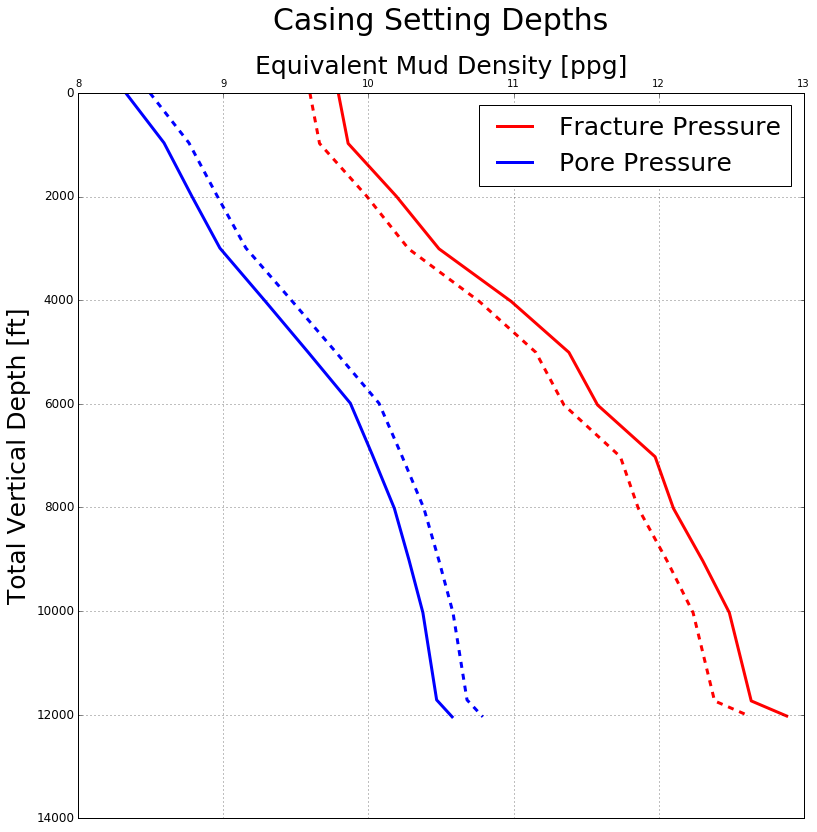

In [4]:
fig, ax = plt.subplots(1, figsize=(13, 13))


# We plot our initial data
ax.plot(fracture_pressure, TVD_frac, color="red", linewidth=3, label="Fracture Pressure")
ax.plot(pore_pressure, TVD_pore, color="blue", linewidth=3, label="Pore Pressure")

# And now our data plus/minus a safety margin of 2%
ax.plot(fracture_pressure_safety, TVD_frac, color="red", linewidth=3, linestyle="--")
ax.plot(pore_pressure_safety, TVD_pore, color="blue", linewidth=3, linestyle="--")

# -------------- Formatting ------------- Ignore for now

ax.set_title("Casing Setting Depths", fontsize=30, y=1.08)
label_size = 12

ax.set_ylabel("Total Vertical Depth [ft]", fontsize=25)
ax.set_ylim(ax.get_ylim()[::-1])

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
ax.set_xlabel("Equivalent Mud Density [ppg]", fontsize=25)
ax.ticklabel_format(fontsize=25)
ax.grid()
ax.legend(fontsize=25)

## Turning theory into code

We now want to turn our list of steps into a piece of working code. Let's start with a naive approach.

We will use **numpy.interp** to compute linear interpolated values from our datasets.
This function takes a list of x values where we want to interpolate (We can compute many at once! Neat!), as well as the x and y values of the data we want to interpolate from. In our case the pore and fracture pressure data.

Since we use a bottom up approach, we know that at the bottom casing setting depth is governed by the pore pressure at the target depth. This is easily found in python by performing list_name[-1] on any list! (Ignore significant digits, you know the drill!)

In [5]:
bottom_up_pore_pressure = pore_pressure_safety[-1]
print "Equivalent pore pressure at depth: ", bottom_up_pore_pressure, " [ppg]"

Equivalent pore pressure at depth:  10.7879955675  [ppg]


Step two now involves extending a line up until we hit the fracture pressure. This means we have to interpolate our known pore pressure at target to find the corresponding depth in our fracture pressure data.
Numpy lets us perform this task in one simple line of code.

In [6]:
second_section_tvd = np.interp(bottom_up_pore_pressure, fracture_pressure_safety, TVD_frac)
print "Depth at which pore pressure and fracture pressure are equal: ", second_section_tvd, " [ft]"

Depth at which pore pressure and fracture pressure are equal:  4085.19350436  [ft]


This depth will be equivalent to our second casing seat (the first was at the target).
Now let's get the pore pressure at this depth. 

To do so we have to switch x and y axis. We know the depth (y-axis) and want to know the pore pressure value (x-axis)
In python this is just as simple as the task before:

In [7]:
second_section_pore_pressure = np.interp(second_section_tvd, TVD_pore, pore_pressure_safety)
print "Equivalent pore pressure for second section: ", second_section_pore_pressure, " [ppg]"

Equivalent pore pressure for second section:  9.49391819579  [ppg]


Great! Now we know the drill (pun not intended :) ) let's see where we hit the frac gradient this time!

In [8]:
third_section_tvd = np.interp(second_section_pore_pressure, fracture_pressure_safety, TVD_frac)
print "Depth at which pore pressure and fracture pressure are equal: ", third_section_tvd, " [ft]"

Depth at which pore pressure and fracture pressure are equal:  0.0  [ft]


We've hit the surface! Therefore, no more casing seats and we are done.
Let's plot the results!

In [9]:
casing_seats_tvd = [TVD_pore[-1], second_section_tvd, second_section_tvd, third_section_tvd]
casing_seats_ppg = [pore_pressure_safety[-1], pore_pressure_safety[-1], second_section_pore_pressure, second_section_pore_pressure]

We will use **matplotlib** to perform any plotting tasks.

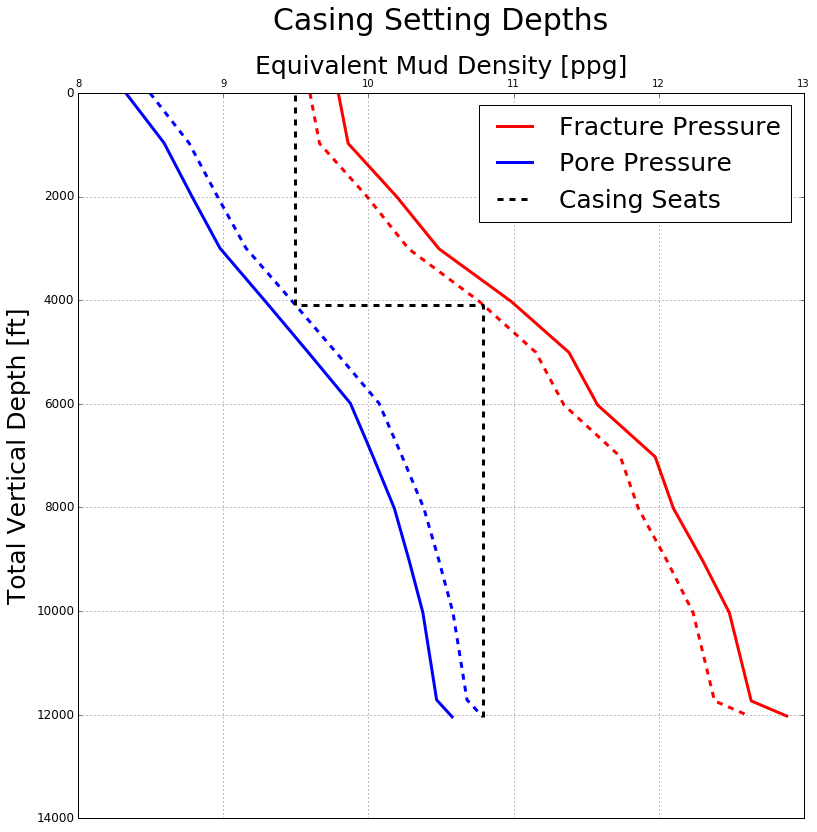

In [10]:
fig, ax = plt.subplots(1, figsize=(13, 13))

# We plot our initial data
ax.plot(fracture_pressure, TVD_frac, color="red", linewidth=3, label="Fracture Pressure")
ax.plot(pore_pressure, TVD_pore, color="blue", linewidth=3, label="Pore Pressure")

# And now our data plus/minus a safety margin of 2%
ax.plot(fracture_pressure_safety, TVD_frac, color="red", linewidth=3, linestyle="--")
ax.plot(pore_pressure_safety, TVD_pore, color="blue", linewidth=3, linestyle="--")

# Finally our casing design
ax.plot(casing_seats_ppg, casing_seats_tvd, color="black", linestyle="--", linewidth=3, label="Casing Seats")

# -------------- Formatting ------------- Ignore for now


ax.set_title("Casing Setting Depths", fontsize=30, y=1.08)
label_size = 12

ax.set_ylabel("Total Vertical Depth [ft]", fontsize=25)
ax.set_ylim(ax.get_ylim()[::-1])

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
ax.set_xlabel("Equivalent Mud Density [ppg]", fontsize=25)
ax.ticklabel_format(fontsize=25)
ax.grid()
ax.legend(fontsize=25)

This concludes part 1 of our casing setting depth determination notebook. Next time we will automate the design process using a simple class. Our third part will deal with abnormal pressure zones and finally we will finish by integrating Microsoft Excel data sources. Until next time!